# Motor Vehicle Death Analysis

After the data cleaning process done in [DataPreparation.ipynb](./DataPreparation.ipynb), let's go ahead with the analysis!

In [104]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [105]:
df = pd.read_csv('df.csv')
df.set_index('FIPS');

# Dataset exploration

## Visual exploration

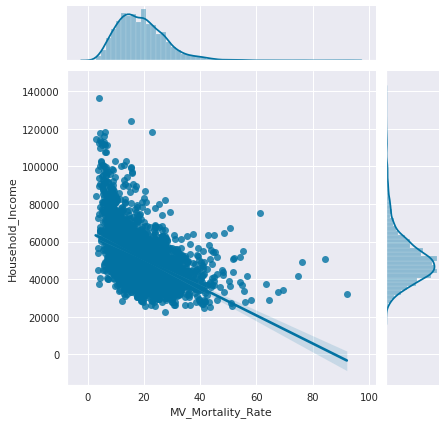

In [106]:
sns.jointplot('MV_Mortality_Rate','Household_Income', data=df, kind='reg');

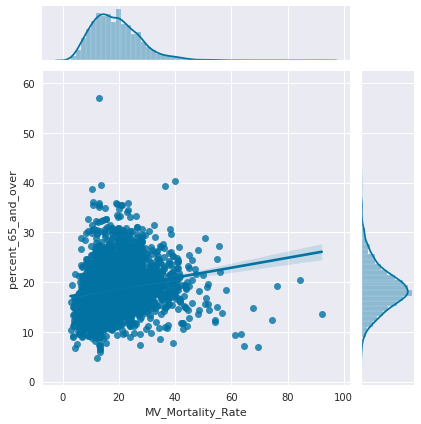

In [110]:
sns.jointplot('MV_Mortality_Rate','percent_65_and_over', data=df, kind='reg');

# Feature selection

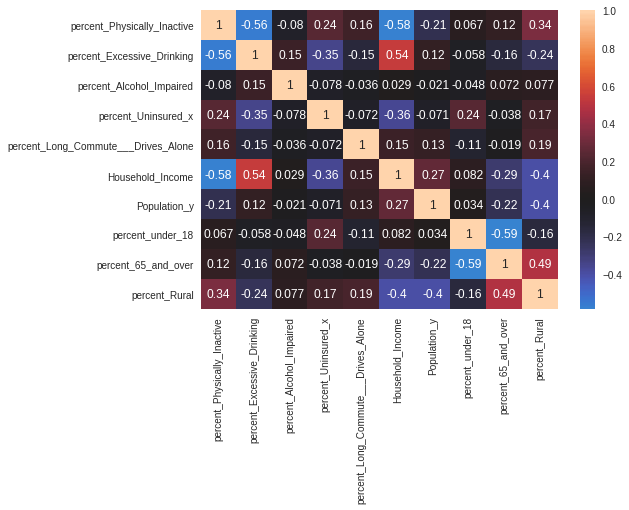

In [4]:
# Original feature list, narrowed down based on vif
# features = ['MV_Mortality_Rate',
#             'Years_of_Potential_Life_Lost_Rate',
#             'percent_Physically_Inactive',
#             'percent_Excessive_Drinking',
#             'percent_Alcohol_Impaired',
#             'percent_Uninsured_x',
#             'Average_Daily_PM25',
#             'percent_Drive_Alone',
#             'percent_Long_Commute___Drives_Alone',
#             'percent_Insufficient_Sleep',
#             'Household_Income',
#             'Population_y',
#             'percent_under_18',
#             'percent_65_and_over',
#             'percent_African_American',
#             'percent_American_Indian_or_Alaskan_Native',
#             'percent_Asian',
#             'percent_Native_Hawaiian_or_Other_Pacific_Islander',
#             'percent_Hispanic',
#             'percent_Non_Hispanic_White',
#             'percent_Not_Proficient_in_English',
#             'percent_Female',
#             'percent_Rural'
#         ]


features = ['MV_Mortality_Rate',
            'percent_Physically_Inactive',
            'percent_Excessive_Drinking',
            'percent_Alcohol_Impaired',
            'percent_Uninsured_x',
            'percent_Long_Commute___Drives_Alone',
            'Household_Income',
            'Population_y',
            'percent_under_18',
            'percent_65_and_over',
            'percent_Rural'


target = df['MV_Mortality_Rate']
dfFeatures = df[features].drop(columns='MV_Mortality_Rate')
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

In [5]:
dfFeatures.corr()

,percent_Physically_Inactive,percent_Excessive_Drinking,percent_Alcohol_Impaired,percent_Uninsured_x,percent_Long_Commute___Drives_Alone,Household_Income,Population_y,percent_under_18,percent_65_and_over,percent_Rural
percent_Physically_Inactive,1.000000,-0.562618,-0.079836,0.238215,0.160794,-0.577904,-0.213562,0.066505,0.118582,0.337525
percent_Excessive_Drinking,-0.562618,1.000000,0.146072,-0.348184,-0.150775,0.539503,0.116615,-0.057803,-0.162691,-0.237913
percent_Alcohol_Impaired,-0.079836,0.146072,1.000000,-0.078359,-0.035783,0.029019,-0.020938,-0.048225,0.071929,0.077000
percent_Uninsured_x,0.238215,-0.348184,-0.078359,1.000000,-0.071670,-0.360481,-0.071082,0.237631,-0.038399,0.167953
percent_Long_Commute___Drives_Alone,0.160794,-0.150775,-0.035783,-0.071670,1.000000,0.150340,0.125439,-0.110645,-0.019270,0.189173
Household_Income,-0.577904,0.539503,0.029019,-0.360481,0.150340,1.000000,0.271010,0.081873,-0.287534,-0.396200
Population_y,-0.213562,0.116615,-0.020938,-0.071082,0.125439,0.271010,1.000000,0.034003,-0.215731,-0.395285
percent_under_18,0.066505,-0.057803,-0.048225,0.237631,-0.110645,0.081873,0.034003,1.000000,-0.587180,-0.159456
percent_65_and_over,0.118582,-0.162691,0.071929,-0.038399,-0.019270,-0.287534,-0.215731,-0.587180,1.000000,0.485344
percent_Rural,0.337525,-0.237913,0.077000,0.167953,0.189173,-0.396200,-0.395285,-0.159456,0.485344,1.000000


Using the VIF, we can assess the list of features we want to include in our model. We are still left with multicollinearity issues but the most obvious ones have been removed.

In [6]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

[('percent_Physically_Inactive', 35.54570813157014),
 ('percent_Excessive_Drinking', 38.79668742722354),
 ('percent_Alcohol_Impaired', 4.91961887492608),
 ('percent_Uninsured_x', 7.610705649820923),
 ('percent_Long_Commute___Drives_Alone', 9.816175466985127),
 ('Household_Income', 32.952387713752),
 ('Population_y', 1.3881167153094347),
 ('percent_under_18', 49.8298787087958),
 ('percent_65_and_over', 22.463061937688472),
 ('percent_Rural', 8.287009034616409)]

# Baseline model

In [7]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2356 786 2356 786


## Linear regression model generation

In [9]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluating the baseline model

In [10]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

fit_time 0.009353542327880859
score_time 0.00232696533203125
test_r2 0.49598654710149004
train_r2 0.5023338274598208
test_neg_mean_squared_error -0.8321782426054968
train_neg_mean_squared_error -0.8201031407874669


As we can see above, our Rsquared value is just above 0.5 for our train dataset and just below 0.5 for our test dataset. This means the model fits the training dataset slighlty better than the test one. However, as we are using a Kfold method, the test dataset is a portion of the training dataset and each portion - or fold - is used sequentially as the test dataset. The 0.49 value is an average of those iterations.

In [11]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

The coefficient for percent_Physically_Inactive is 0.18236
The coefficient for percent_Excessive_Drinking is -0.04499
The coefficient for percent_Alcohol_Impaired is 0.04753
The coefficient for percent_Uninsured_x is 0.2108
The coefficient for percent_Long_Commute___Drives_Alone is 0.05258
The coefficient for Household_Income is -0.21915
The coefficient for Population_y is -0.04576
The coefficient for percent_under_18 is 0.29698
The coefficient for percent_65_and_over is 0.11152
The coefficient for percent_Rural is 0.48421
----------------------
The intercept is 2.723747214690111


In [12]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

Train Mean Squarred Error: 0.8212659953514022
Train Rsquared:0.501546593853755


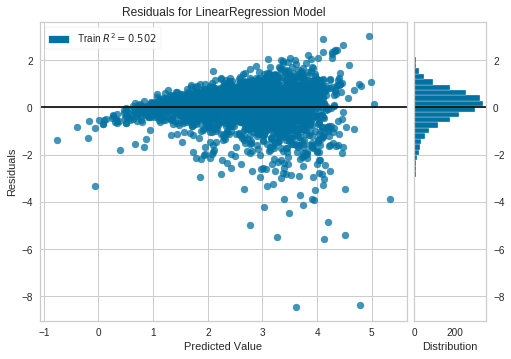

In [24]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();

This graph tells us there is a bias and it is heteroscedastic (higher predicted values have more variance)

# Overfitting the model

In this section, we are going to polynomise our train dataset in order to maximise the Rsquared value (the goodness of fit indicator). We've tried all integers up to 5 (Rsquared = 1) but a cubic transformation brings a 0.64 Rsquare value which is more than enough considering the feature expansion trade-off. (considering our 10 variables, a third degree polynomial means we have about 286 features and interactions to analyse, a fourth degree brings us to 1001!)

In [122]:
# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

# Standardisation
X_poly_s = scaler.fit_transform(X_poly)

# Modellisation
model = LinearRegression()
lin_reg_1 = model.fit(X_poly_s,y_train)

# Evaluation
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared: {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

Rsquared: 0.6411292451761765


In [123]:
X_poly_s.shape

(2356, 286)

# Reducing the fit: LASSO, Ridge and Elastic net regressions

### Hyperparameter tuning

We are going to use GridSearchCV in order to automatise the search of the best alpha value to use. the `np.linspace()` parameters were manually changed depending on the results returned. We would narrow the parameters down closer to the result returned so on the next pass, alpha would be more accurate.

Cells have been commented out because they take a reasonable amount of time to compute.

In [23]:
# ridge = Ridge()
# # alpha was narrowed down manually
# ridge_params = {'alpha' : np.linspace(503,505)}

# grid = GridSearchCV(estimator = ridge, 
#                     param_grid = ridge_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 503.81633
## Rsquared: 0.52342

# pd.DataFrame(grid.cv_results_) give the detail of the cross validation results for all the alpha values

KeyboardInterrupt: 

In [15]:
# lasso = Lasso()
# # alpha was narrowed down manually
# lasso_params = {'alpha' : np.linspace(.004, .005)}

# grid = GridSearchCV(estimator = lasso, 
#                     param_grid = lasso_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.00469
## Rsquared: 0.52799

alpha: 0.00469
Rsquared: 0.52799


In [16]:
# enet = ElasticNet()
# # alpha was narrowed down manually
# elastic_params = {'alpha' : np.linspace(0, .5)}

# grid = GridSearchCV(estimator = enet, 
#                     param_grid = elastic_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.0102
## Rsquared: 0.52825

alpha: 0.0102
Rsquared: 0.52825


## Model selection

Based on Rsquared values, the ElasticNet (0.52825) performes better than the Lasso (0.52799) which performs better than the Ridge model (0.52342). However, considering our polynomial is cubic, we are going to select the Lasso model as it removes most of the features generated during the polynomisation step. This will hopefully allow the model to be more interpretable.

Here is a summary of the coefficients, for informational purposes only.

In [17]:
ridge = Ridge(alpha=503.81633)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)

enet = ElasticNet(alpha=0.0102)
enet.fit(X_poly_s, y_train)

# The following coefficients are transformed and scaled
# (as they work on the _poly_ data)
print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)
print('----------------------')
print('Elastic net parameter coefficients:', enet.coef_)

LinearRegression parameter coefficients: [ 0.1823552  -0.04498776  0.04752823  0.21080244  0.0525807  -0.21915116
 -0.04575683  0.29697762  0.11152051  0.48421046]
----------------------
Ridge parameter coefficients: [ 0.00000000e+00  2.99888164e-02 -3.78678249e-02  4.29079045e-03
  1.44632403e-02  1.16886103e-02 -3.69217120e-02 -1.05979962e-02
  9.41032261e-03  3.12682647e-02  4.73729125e-02  3.36285298e-02
 -3.04307110e-02  6.58773444e-03  1.71229590e-02  1.52727066e-02
 -2.73897631e-02 -1.32182963e-02  3.54393005e-02  1.63381051e-02
  4.42485755e-02 -1.41328256e-02  2.87393234e-03  2.48753548e-02
 -1.25531470e-02 -6.86281002e-03 -7.28292078e-03 -9.70828120e-03
 -1.26651757e-03  1.37981062e-02 -1.13608104e-02  7.98458327e-03
  1.34233833e-02 -1.33447338e-02  2.36350017e-04  1.11424538e-02
  2.14865465e-03  2.05311432e-02 -1.67171460e-02  2.07048792e-02
 -8.47628347e-03 -9.87214948e-03  1.79066221e-02  2.52194484e-02
  1.04178134e-02  4.62918656e-03 -1.75632507e-02  4.67701696e-03
  1

# Testing the model

Training score: 0.5604116754987079
Testing score: 0.5643265991025366


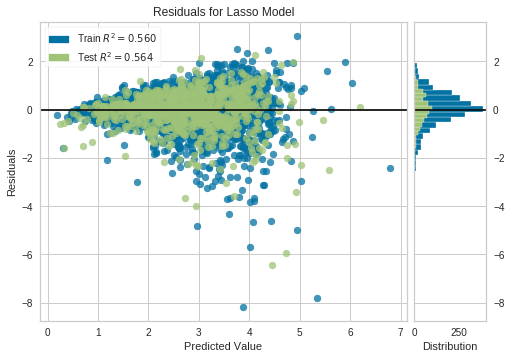

In [56]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_poly_s = scaler.transform(X_poly)

X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Testing score: {lasso.score(X_test_poly_s,y_test)}')
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_poly_s, y_train)
visualizer.score(X_test_poly_s, y_test)
visualizer.show();

As shown above, the test residuals 'match' the train residuals; the scores are comparable. This tells us the model is robust. The scores are relatively low (56%) but it is better than the 50% we had in our baseline model.

The residuals graph shows there is a bias in the data, and there is some heteroscedasticity. We think by doing a better job at selecting our features this could be optimised.

The number of features, as well as the features themselves, used in this model were selected on an intuitive basis. We did this in order to improve the interpretability of the model, as opposed to select more variables or more complex interactions in order to get a more accurate model.

## Weight of the variables/interactions

In this section we are going to descale and defactorise our coefficients so we will be able to see in which extent the affect the MVD.

In [102]:
coefname = poly_reg.get_feature_names(X_train.columns)
coefvalue = lasso.coef_
df = pd.DataFrame(list(zip(coefname,coefvalue)))
df.columns = ['Coefficient','ScaledValue']
df['PolyValue'] = scaler.inverse_transform(df['ScaledValue'])
df['Value'] = df['PolyValue']**(1./3)
df = df[df['ScaledValue']!=0]
df = df.sort_values(by='Value', ascending=False)
df

,Coefficient,ScaledValue,PolyValue,Value
251,Household_Income^3,0.020145,1.714546e+14,55554.130990
220,percent_Uninsured_x Population_y^2,0.002774,1.429536e+12,11265.012145
269,Population_y^2 percent_Rural,0.046407,4.584404e+11,7710.708717
259,Household_Income Population_y percent_Rural,-0.032197,1.022766e+11,4676.548584
151,percent_Excessive_Drinking Household_Income^2,0.173702,5.808431e+10,3872.751272
265,Household_Income percent_Rural^2,-0.012480,2.064207e+08,590.995837
275,Population_y percent_Rural^2,-0.144172,8.376832e+07,437.548904
244,percent_Long_Commute___Drives_Alone Population...,0.250721,8.281248e+07,435.878323
270,Population_y percent_under_18^2,-0.023822,5.019705e+07,368.886476
72,percent_Physically_Inactive^2 Population_y,-0.041091,4.788232e+07,363.126879


In [115]:
lasso.intercept_

2.7237472146901083